# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
#Удаляю дубликаты
data.drop_duplicates(inplace=True)
print('Количество дубликатов', data.duplicated().sum())

Количество дубликатов 0


In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
#Удаляю ненужные признаки
filtered_data = data.drop(
    ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [8]:
#Количество пропусков
filtered_data.isna().sum().sort_values(ascending=False)

Repaired            71154
VehicleType         37490
FuelType            32895
Gearbox             19833
Model               19705
Price                   0
RegistrationYear        0
Power                   0
Kilometer               0
Brand                   0
dtype: int64

In [9]:
#Заменяю nan на yes
print('Уникальные значения:', filtered_data['Repaired'].unique())
filtered_data['Repaired'] = filtered_data['Repaired'].fillna('yes')
print('Количество пропусков:', filtered_data['Repaired'].isna().sum())

Уникальные значения: [nan 'yes' 'no']
Количество пропусков: 0


In [10]:
#Заменяю nan на unknowm
print('Уникальные значения:',  filtered_data['VehicleType'].unique())
filtered_data['VehicleType'] = filtered_data['VehicleType'].fillna('unknown')
print('Количество пропусков:', filtered_data['VehicleType'].isna().sum())

Уникальные значения: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Количество пропусков: 0


In [11]:
#Заменяю nan на unknowm и petrol на gasoline, так как это одно и тоже
print('Уникальные значения:', filtered_data['FuelType'].unique())
filtered_data.loc[filtered_data['FuelType'] == 'petrol', 'FuelType'] = 'gasoline'
filtered_data['FuelType'] = filtered_data['FuelType'].fillna('unknown')
print(filtered_data['FuelType'].isna().sum())

Уникальные значения: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
0


In [12]:
#Заменяю nan на manual
print('Уникальные значения:', filtered_data['Gearbox'].unique())
filtered_data['Gearbox'] = filtered_data['Gearbox'].fillna('manual')
print('Количество пропусков:', filtered_data['Gearbox'].isna().sum())

Уникальные значения: ['manual' 'auto' nan]
Количество пропусков: 0


In [13]:
#Заменяю nan на unknowm
print('Уникальные значения:', filtered_data['Model'].unique())
filtered_data['Model'] = filtered_data['Model'].fillna('unknown')
print('Количество пропусков:', filtered_data['Model'].isna().sum())

Уникальные значения: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa

In [14]:
#Пропуски исправлены
filtered_data.isna().sum().sort_values(ascending=False)

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

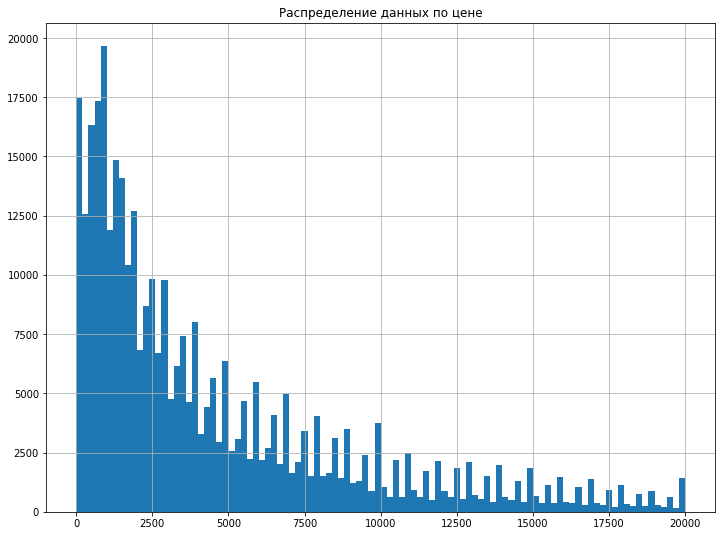

In [15]:
#Распределение целевого признака, есть нулевые и очень маленькие значения
filtered_data['Price'].hist(bins=100, figsize=(12,9))
plt.title('Распределение данных по цене')
plt.show()

In [16]:
filtered_data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

In [17]:
#Оставляю цену выше 400 евро
filtered_data = filtered_data.query('Price>400')
filtered_data['Price'].value_counts()

500      5670
1500     5394
1000     4648
1200     4594
2500     4438
         ... 
11955       1
6996        1
1879        1
6235        1
8188        1
Name: Price, Length: 3508, dtype: int64

In [18]:
#По году регистрации автомобиля есть вопросы. Слижком маленькие и большие значения
filtered_data['RegistrationYear'].value_counts().sort_index()

1000    14
1001     1
1039     1
1111     1
1234     1
        ..
8500     1
8888     1
9000     2
9450     1
9999    10
Name: RegistrationYear, Length: 133, dtype: int64

In [19]:
#Оставляю данные с 1970 по актуальный год - 2023
filtered_data = filtered_data.query('1970<RegistrationYear<2024')
filtered_data['RegistrationYear'].value_counts().sort_index()

1971      157
1972      208
1973      161
1974      166
1975      135
1976      150
1977      164
1978      272
1979      265
1980      419
1981      242
1982      298
1983      393
1984      374
1985      595
1986      476
1987      583
1988      855
1989     1119
1990     2065
1991     2273
1992     2438
1993     2646
1994     3759
1995     6663
1996     8394
1997    11419
1998    15072
1999    19982
2000    20254
2001    18951
2002    18379
2003    19300
2004    19243
2005    21110
2006    19623
2007    16963
2008    15212
2009    14359
2010    10638
2011     9803
2012     7086
2013     4047
2014     2448
2015     1072
2016     7187
2017     9375
2018     3740
2019       13
Name: RegistrationYear, dtype: int64

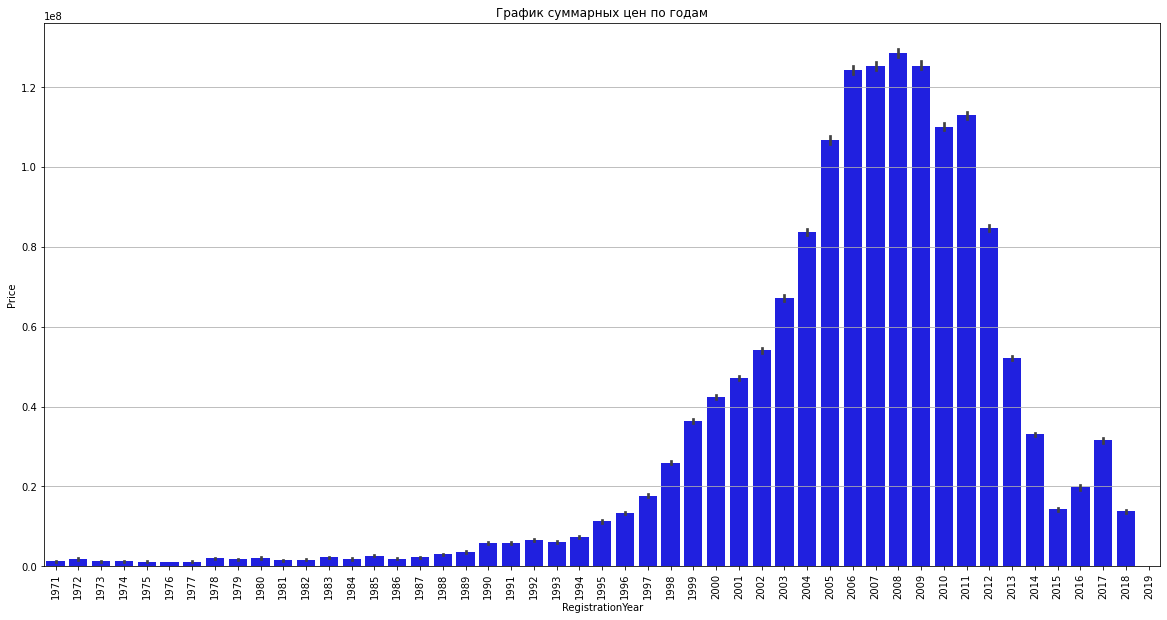

In [20]:
#Смотрю распределение суммарной стоимости по годам. Больше всего продаются автомобили с 00-ми и 10-ми годами выпуска
plt.figure(figsize=(20,10))
plt.grid()
plt.title('График суммарных цен по годам')
sns.barplot(x='RegistrationYear', y='Price', data=filtered_data, color='blue', estimator=sum);
plt.xticks(rotation=90)
plt.show()

In [21]:
power = filtered_data['Power'].unique()
power.sort()
power

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    33,    34,    35,    36,
          37,    38,    39,    40,    41,    42,    43,    44,    45,
          46,    47,    48,    49,    50,    51,    52,    53,    54,
          55,    56,    57,    58,    59,    60,    61,    62,    63,
          64,    65,    66,    67,    68,    69,    70,    71,    72,
          73,    74,    75,    76,    77,    78,    79,    80,    81,
          82,    83,    84,    85,    86,    87,    88,    89,    90,
          91,    92,    93,    94,    95,    96,    97,    98,    99,
         100,   101,   102,   103,   104,   105,   106,   107,   108,
         109,   110,   111,   112,   113,   114,   115,   116,   117,
         118,   119,   120,   121,   122,   123,   124,   125,   126,
         127,   128,

In [22]:
#Оставляю данные по мощности от 50 лс до 400 лс
filtered_data = filtered_data.query('50<Power<400')

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


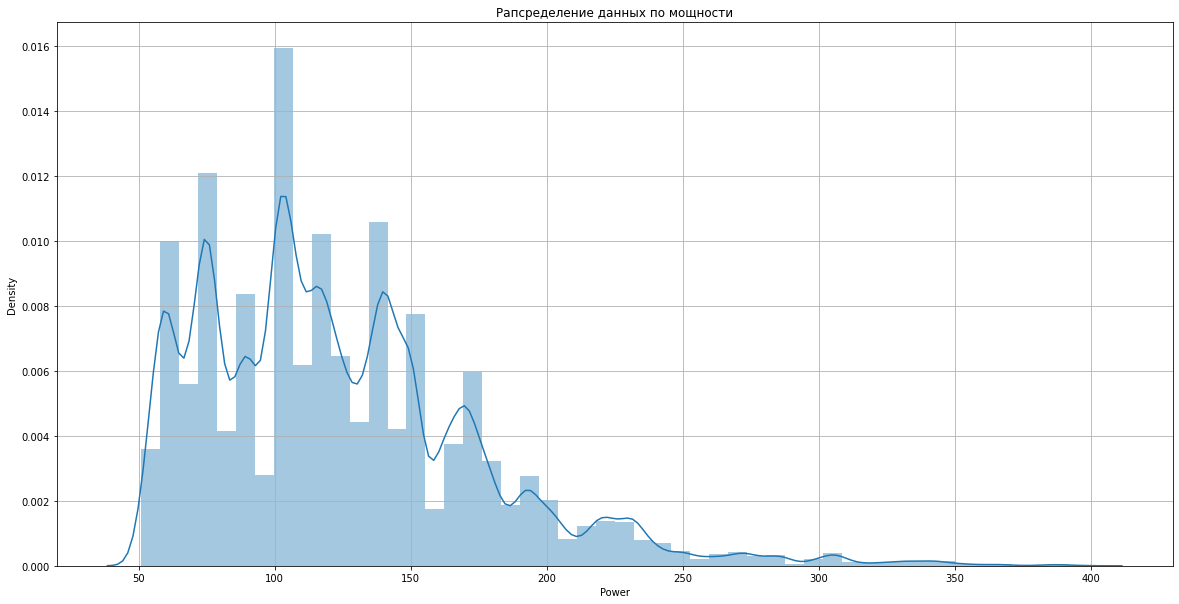

In [23]:
plt.figure(figsize=(20,10))
plt.grid()
plt.title('Рапсределение данных по мощности')
sns.distplot(filtered_data['Power'])
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


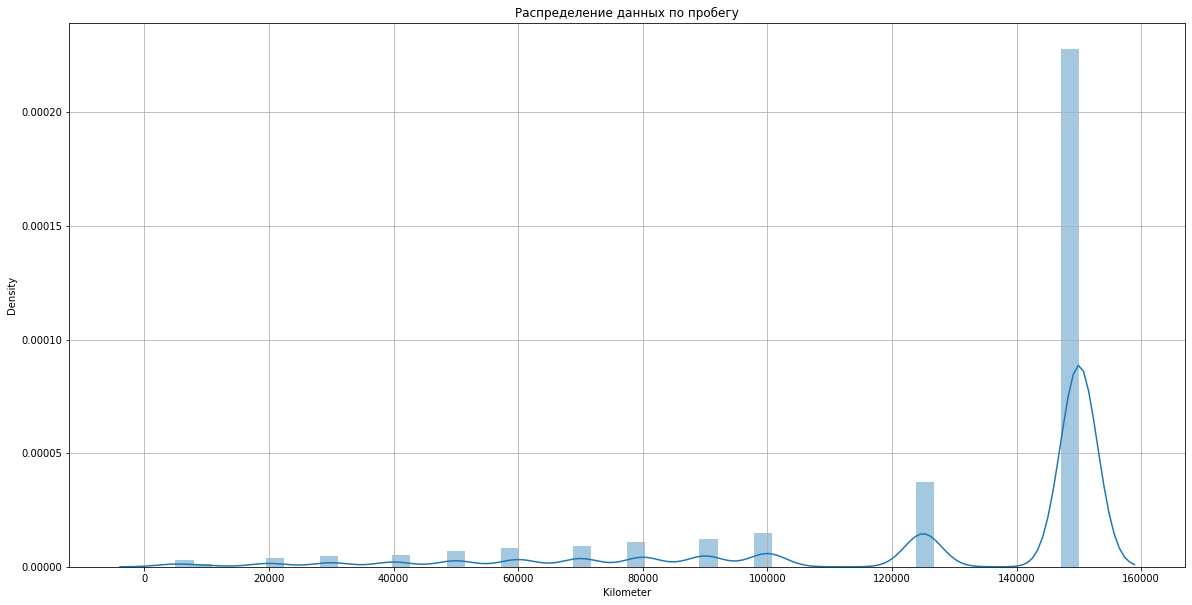

In [24]:
#Данные по пробегу не требуют вмешательства
plt.figure(figsize=(20,10))
plt.grid()
plt.title('Распределение данных по пробегу')
sns.distplot(filtered_data['Kilometer'])
plt.show()

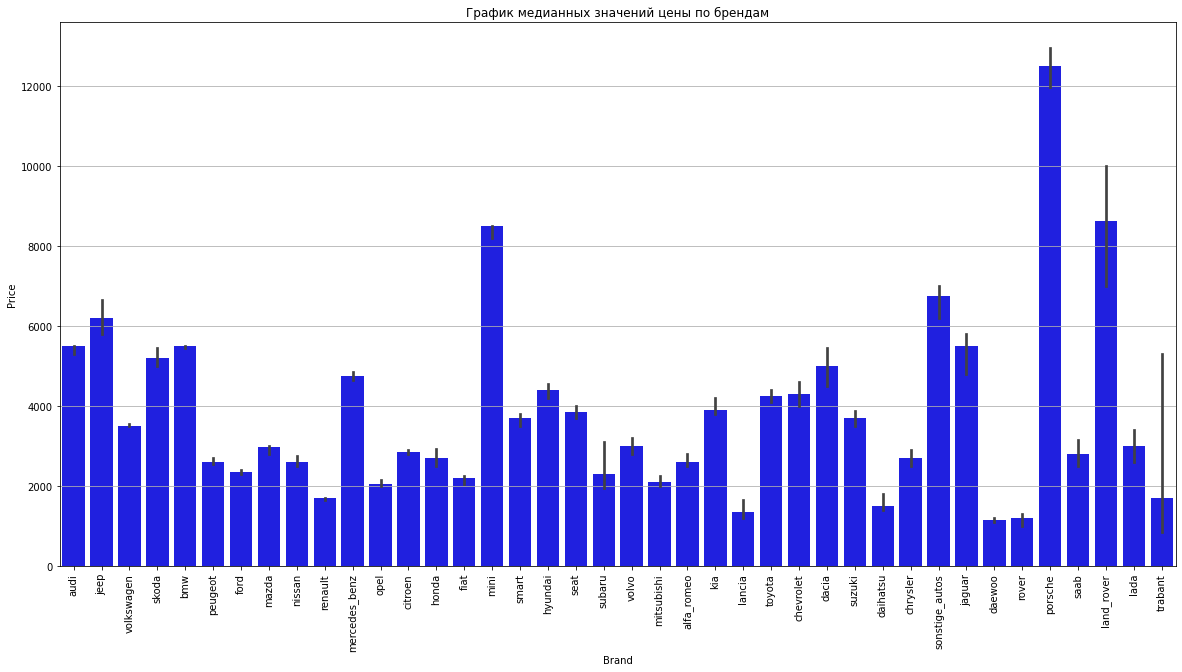

In [25]:
#По бренду тоже не требуют корректировок
plt.figure(figsize=(20,10))
plt.grid()
plt.title('График медианных значений цены по брендам')
sns.barplot(x='Brand', y='Price', data=filtered_data, color='blue', estimator=np.median);
plt.xticks(rotation=90)
plt.show()

In [26]:
filtered_data.reset_index(drop=True, inplace=True)

In [27]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282995 entries, 0 to 282994
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             282995 non-null  int64 
 1   VehicleType       282995 non-null  object
 2   RegistrationYear  282995 non-null  int64 
 3   Gearbox           282995 non-null  object
 4   Power             282995 non-null  int64 
 5   Model             282995 non-null  object
 6   Kilometer         282995 non-null  int64 
 7   FuelType          282995 non-null  object
 8   Brand             282995 non-null  object
 9   Repaired          282995 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.6+ MB


<b>Вывод</b>
Удалил не нужные признаки, заполнил пропуски в столбцах и удалил выбросы или подозрительные значения. Удалил около 30% данных.

In [28]:
#Делю на признаки и целевой признак
features = filtered_data.drop('Price', axis=1)
target = filtered_data['Price']

In [29]:
features_ohe = pd.get_dummies(features, drop_first=True)

In [30]:
#Дроблю на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=0.2,
                                                                            random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(features_train,
                                                                              target_train, 
                                                                              test_size=0.25,
                                                                              random_state=12345)

In [31]:
features_train_ohe = features_ohe.loc[features_train.index, :]
features_valid_ohe = features_ohe.loc[features_valid.index, :]
features_test_ohe = features_ohe.loc[features_test.index, :]

display(features_train_ohe, features_valid_ohe, features_test_ohe)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
60881,2013,150,20000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210584,1998,170,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61596,2009,143,90000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106699,2007,140,70000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169158,2005,105,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13921,1998,101,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161491,2012,170,90000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72226,2013,140,10000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265912,2001,82,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
41923,2008,160,70000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111068,1999,60,80000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24225,2009,100,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
125927,2004,125,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
129824,2001,101,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195863,2005,139,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234439,2001,197,150000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173958,2001,105,150000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
268664,1999,102,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
247140,2003,136,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
65050,1995,68,125000,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
90869,1995,150,150000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
280385,1998,150,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
262115,2002,211,150000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217805,2007,235,125000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
52822,2000,193,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10905,1998,151,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30841,1995,75,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
#Кодирую категориальные признаки в данных
encoder = OrdinalEncoder()
cat_columns = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'Repaired']
cat_features_train = features_train[cat_columns]
cat_features_train = pd.DataFrame(encoder.fit_transform(cat_features_train),
                                columns=cat_features_train.columns, 
                                index=cat_features_train.index)
features_train_oe = features_train.copy()
for column in cat_columns:
    features_train_oe[column] = cat_features_train[column]



cat_features_valid = features_valid[cat_columns]
cat_features_valid = pd.DataFrame(encoder.transform(cat_features_valid),
                                columns=cat_features_valid.columns, 
                                index=cat_features_valid.index)
features_valid_oe = features_valid.copy()
for column in cat_columns:
    features_valid_oe[column] = cat_features_valid[column]



cat_features_test = features_test[cat_columns]
cat_features_test = pd.DataFrame(encoder.transform(cat_features_test),
                                columns=cat_features_test.columns, 
                                index=cat_features_test.index)
features_test_oe = features_test.copy()
for column in cat_columns:
    features_test_oe[column] = cat_features_test[column]
    
    
    
display(features_train_oe, features_valid_oe, features_test_oe)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
60881,8.0,2013,1.0,150,59.0,20000,2.0,10.0,0.0
210584,8.0,1998,1.0,170,15.0,150000,2.0,2.0,0.0
61596,1.0,2009,1.0,143,6.0,90000,2.0,2.0,0.0
106699,1.0,2007,0.0,140,10.0,70000,2.0,25.0,0.0
169158,8.0,2005,1.0,105,61.0,150000,2.0,38.0,0.0
...,...,...,...,...,...,...,...,...,...
13921,4.0,1998,1.0,101,28.0,150000,2.0,1.0,0.0
161491,4.0,2012,1.0,170,139.0,90000,2.0,30.0,0.0
72226,8.0,2013,1.0,140,41.0,10000,2.0,24.0,0.0
265912,0.0,2001,1.0,82,236.0,150000,2.0,20.0,0.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
41923,1.0,2008,1.0,160,157.0,70000,2.0,19.0,0.0
111068,4.0,1999,1.0,60,127.0,80000,2.0,10.0,0.0
24225,6.0,2009,1.0,100,179.0,125000,2.0,23.0,1.0
125927,0.0,2004,1.0,125,248.0,150000,6.0,24.0,1.0
129824,8.0,2001,1.0,101,41.0,150000,2.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...
195863,8.0,2005,1.0,139,135.0,150000,2.0,27.0,0.0
234439,1.0,2001,0.0,197,75.0,150000,2.0,20.0,0.0
173958,2.0,2001,1.0,105,11.0,150000,6.0,2.0,1.0
268664,5.0,1999,1.0,102,32.0,150000,6.0,20.0,1.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
247140,0.0,2003,1.0,136,220.0,150000,2.0,38.0,0.0
65050,8.0,1995,1.0,68,226.0,125000,2.0,31.0,1.0
90869,1.0,1995,1.0,150,19.0,150000,6.0,1.0,1.0
280385,4.0,1998,1.0,150,226.0,150000,2.0,1.0,1.0
262115,6.0,2002,0.0,211,70.0,150000,4.0,14.0,0.0
...,...,...,...,...,...,...,...,...,...
217805,4.0,2007,0.0,235,15.0,125000,2.0,2.0,1.0
52822,8.0,2000,1.0,193,11.0,150000,2.0,2.0,0.0
10905,0.0,1998,1.0,151,222.0,150000,2.0,38.0,0.0
30841,4.0,1995,1.0,75,115.0,150000,2.0,38.0,0.0


In [33]:
#Масштабирую количественные признаках исходных
quan_columns = ['RegistrationYear', 'Power', 'Kilometer']
quan_features_train = features_train[quan_columns]
scaler = StandardScaler()
scaler.fit(quan_features_train)
quan_features_train_scaled = pd.DataFrame(scaler.transform(quan_features_train),
                                          columns = quan_features_train.columns,
                                          index = quan_features_train.index)
features_train_scaled = features_train.copy()
for column in quan_columns:
    features_train_scaled[column] = quan_features_train_scaled[column]




quan_features_valid = features_valid[quan_columns]

quan_features_valid_scaled = pd.DataFrame(scaler.transform(quan_features_valid),
                                          columns = quan_features_valid.columns,
                                          index = quan_features_valid.index)
features_valid_scaled = features_valid.copy()
for column in quan_columns:
    features_valid_scaled[column] = quan_features_valid_scaled[column]
    
    
    
quan_features_test = features_test[quan_columns]

quan_features_test_scaled = pd.DataFrame(scaler.transform(quan_features_test),
                                          columns = quan_features_test.columns,
                                          index = quan_features_test.index)
features_test_scaled = features_test.copy()
for column in quan_columns:
    features_test_scaled[column] = quan_features_test_scaled[column]


    
display(features_train_scaled, features_valid_scaled, features_test_scaled)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
60881,wagon,1.440243,manual,0.506464,c_max,-2.957251,gasoline,ford,no
210584,wagon,-0.900450,manual,0.895864,5er,0.594006,gasoline,bmw,no
61596,convertible,0.816058,manual,0.370174,1er,-1.045035,gasoline,bmw,no
106699,convertible,0.503965,auto,0.311764,3_reihe,-1.591383,gasoline,peugeot,no
169158,wagon,0.191873,manual,-0.369685,caddy,0.594006,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...
13921,sedan,-0.900450,manual,-0.447565,a4,0.594006,gasoline,audi,no
161491,sedan,1.284196,manual,0.895864,leon,-1.045035,gasoline,seat,no
72226,wagon,1.440243,manual,0.311764,astra,-3.230424,gasoline,opel,no
265912,bus,-0.432312,manual,-0.817494,vito,0.594006,gasoline,mercedes_benz,no


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
41923,convertible,0.660012,manual,0.701164,mx_reihe,-1.591383,gasoline,mazda,no
111068,sedan,-0.744404,manual,-1.245833,ka,-1.318209,gasoline,ford,no
24225,suv,0.816058,manual,-0.467035,qashqai,-0.088928,gasoline,nissan,yes
125927,bus,0.035827,manual,0.019715,zafira,0.594006,unknown,opel,yes
129824,wagon,-0.432312,manual,-0.447565,astra,0.594006,gasoline,opel,no
...,...,...,...,...,...,...,...,...,...
195863,wagon,0.191873,manual,0.292294,laguna,0.594006,gasoline,renault,no
234439,convertible,-0.432312,auto,1.421553,clk,0.594006,gasoline,mercedes_benz,no
173958,coupe,-0.432312,manual,-0.369685,3er,0.594006,unknown,bmw,yes
268664,small,-0.744404,manual,-0.428095,a_klasse,0.594006,unknown,mercedes_benz,yes


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
247140,bus,-0.120219,manual,0.233884,touran,0.594006,gasoline,volkswagen,no
65050,wagon,-1.368589,manual,-1.090074,unknown,-0.088928,gasoline,skoda,yes
90869,convertible,-1.368589,manual,0.506464,80,0.594006,unknown,audi,yes
280385,sedan,-0.900450,manual,0.506464,unknown,0.594006,gasoline,audi,yes
262115,suv,-0.276265,auto,1.694132,cherokee,0.594006,lpg,jeep,no
...,...,...,...,...,...,...,...,...,...
217805,sedan,0.503965,auto,2.161412,5er,-0.088928,gasoline,bmw,yes
52822,wagon,-0.588358,manual,1.343673,3er,0.594006,gasoline,bmw,no
10905,bus,-0.900450,manual,0.525934,transporter,0.594006,gasoline,volkswagen,no
30841,sedan,-1.368589,manual,-0.953784,golf,0.594006,gasoline,volkswagen,no


In [34]:
#Масштабирую количественные признаки ОЕ
quan_features_train_oe = features_train[quan_columns]

quan_features_train_oe_scaled = pd.DataFrame(scaler.transform(quan_features_train_oe),
                                          columns = quan_features_train_oe.columns,
                                          index = quan_features_train_oe.index)
features_train_oe_scaled = features_train_oe.copy()
for column in quan_columns:
    features_train_oe_scaled[column] = quan_features_train_oe_scaled[column]
    
    

quan_features_valid_oe = features_valid[quan_columns]

quan_features_valid_oe_scaled = pd.DataFrame(scaler.transform(quan_features_valid_oe),
                                          columns = quan_features_valid_oe.columns,
                                          index = quan_features_valid_oe.index)
features_valid_oe_scaled = features_valid_oe.copy()
for column in quan_columns:
    features_valid_oe_scaled[column] = quan_features_valid_oe_scaled[column]
    

    
quan_features_test_oe = features_test[quan_columns]

quan_features_test_oe_scaled = pd.DataFrame(scaler.transform(quan_features_test_oe),
                                          columns = quan_features_test_oe.columns,
                                          index = quan_features_test_oe.index)
features_test_oe_scaled = features_test_oe.copy()
for column in quan_columns:
    features_test_oe_scaled[column] = quan_features_test_oe_scaled[column]
    

    
display(features_train_oe_scaled, features_valid_oe_scaled, features_test_oe_scaled)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
60881,8.0,1.440243,1.0,0.506464,59.0,-2.957251,2.0,10.0,0.0
210584,8.0,-0.900450,1.0,0.895864,15.0,0.594006,2.0,2.0,0.0
61596,1.0,0.816058,1.0,0.370174,6.0,-1.045035,2.0,2.0,0.0
106699,1.0,0.503965,0.0,0.311764,10.0,-1.591383,2.0,25.0,0.0
169158,8.0,0.191873,1.0,-0.369685,61.0,0.594006,2.0,38.0,0.0
...,...,...,...,...,...,...,...,...,...
13921,4.0,-0.900450,1.0,-0.447565,28.0,0.594006,2.0,1.0,0.0
161491,4.0,1.284196,1.0,0.895864,139.0,-1.045035,2.0,30.0,0.0
72226,8.0,1.440243,1.0,0.311764,41.0,-3.230424,2.0,24.0,0.0
265912,0.0,-0.432312,1.0,-0.817494,236.0,0.594006,2.0,20.0,0.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
41923,1.0,0.660012,1.0,0.701164,157.0,-1.591383,2.0,19.0,0.0
111068,4.0,-0.744404,1.0,-1.245833,127.0,-1.318209,2.0,10.0,0.0
24225,6.0,0.816058,1.0,-0.467035,179.0,-0.088928,2.0,23.0,1.0
125927,0.0,0.035827,1.0,0.019715,248.0,0.594006,6.0,24.0,1.0
129824,8.0,-0.432312,1.0,-0.447565,41.0,0.594006,2.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...
195863,8.0,0.191873,1.0,0.292294,135.0,0.594006,2.0,27.0,0.0
234439,1.0,-0.432312,0.0,1.421553,75.0,0.594006,2.0,20.0,0.0
173958,2.0,-0.432312,1.0,-0.369685,11.0,0.594006,6.0,2.0,1.0
268664,5.0,-0.744404,1.0,-0.428095,32.0,0.594006,6.0,20.0,1.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
247140,0.0,-0.120219,1.0,0.233884,220.0,0.594006,2.0,38.0,0.0
65050,8.0,-1.368589,1.0,-1.090074,226.0,-0.088928,2.0,31.0,1.0
90869,1.0,-1.368589,1.0,0.506464,19.0,0.594006,6.0,1.0,1.0
280385,4.0,-0.900450,1.0,0.506464,226.0,0.594006,2.0,1.0,1.0
262115,6.0,-0.276265,0.0,1.694132,70.0,0.594006,4.0,14.0,0.0
...,...,...,...,...,...,...,...,...,...
217805,4.0,0.503965,0.0,2.161412,15.0,-0.088928,2.0,2.0,1.0
52822,8.0,-0.588358,1.0,1.343673,11.0,0.594006,2.0,2.0,0.0
10905,0.0,-0.900450,1.0,0.525934,222.0,0.594006,2.0,38.0,0.0
30841,4.0,-1.368589,1.0,-0.953784,115.0,0.594006,2.0,38.0,0.0


In [35]:
#Масштабирую количественные признаки ОНЕ
quan_features_train_ohe = features_train[quan_columns]

quan_features_train_ohe_scaled = pd.DataFrame(scaler.transform(quan_features_train_ohe),
                                          columns = quan_features_train_ohe.columns,
                                          index = quan_features_train_ohe.index)
features_train_ohe_scaled = features_train_ohe.copy()
for column in quan_columns:
    features_train_ohe_scaled[column] = quan_features_train_ohe_scaled[column]
    
    

quan_features_valid_ohe = features_valid[quan_columns]

quan_features_valid_ohe_scaled = pd.DataFrame(scaler.transform(quan_features_valid_ohe),
                                          columns = quan_features_valid_ohe.columns,
                                          index = quan_features_valid_ohe.index)
features_valid_ohe_scaled = features_valid_ohe.copy()
for column in quan_columns:
    features_valid_ohe_scaled[column] = quan_features_valid_ohe_scaled[column]
    

    
quan_features_test_ohe = features_test[quan_columns]

quan_features_test_ohe_scaled = pd.DataFrame(scaler.transform(quan_features_test_ohe),
                                          columns = quan_features_test_ohe.columns,
                                          index = quan_features_test_ohe.index)
features_test_ohe_scaled = features_test_ohe.copy()
for column in quan_columns:
    features_test_ohe_scaled[column] = quan_features_test_ohe_scaled[column]
    

    
display(features_train_ohe_scaled, features_valid_ohe_scaled, features_test_ohe_scaled)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
60881,1.440243,0.506464,-2.957251,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210584,-0.900450,0.895864,0.594006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61596,0.816058,0.370174,-1.045035,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106699,0.503965,0.311764,-1.591383,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169158,0.191873,-0.369685,0.594006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13921,-0.900450,-0.447565,0.594006,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161491,1.284196,0.895864,-1.045035,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72226,1.440243,0.311764,-3.230424,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265912,-0.432312,-0.817494,0.594006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
41923,0.660012,0.701164,-1.591383,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111068,-0.744404,-1.245833,-1.318209,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24225,0.816058,-0.467035,-0.088928,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
125927,0.035827,0.019715,0.594006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
129824,-0.432312,-0.447565,0.594006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195863,0.191873,0.292294,0.594006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234439,-0.432312,1.421553,0.594006,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173958,-0.432312,-0.369685,0.594006,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
268664,-0.744404,-0.428095,0.594006,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
247140,-0.120219,0.233884,0.594006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
65050,-1.368589,-1.090074,-0.088928,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
90869,-1.368589,0.506464,0.594006,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
280385,-0.900450,0.506464,0.594006,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
262115,-0.276265,1.694132,0.594006,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217805,0.503965,2.161412,-0.088928,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
52822,-0.588358,1.343673,0.594006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10905,-0.900450,0.525934,0.594006,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30841,-1.368589,-0.953784,0.594006,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [36]:
%%time
#Линейная регрессия
linear = LinearRegression()
linear.fit(features_train_ohe_scaled, target_train)
linear_predict_valid = linear.predict(features_valid_ohe_scaled)
print('RMSE valid:', mean_squared_error(target_valid, linear_predict_valid) ** 0.5)
print()

RMSE valid: 2526.1651532088636

CPU times: user 14.9 s, sys: 13.2 s, total: 28.1 s
Wall time: 28.2 s


In [37]:
%%time
#Дерево решений
best_result = 2500
depth = 0
depths = []
results = []

for depth in range(1, 21, 2):
    tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    tree.fit(features_train_oe_scaled, target_train)
    tree_predict_valid = tree.predict(features_valid_oe_scaled)
    result = mean_squared_error(target_valid, tree_predict_valid) ** 0.5
    depths.append(depth)
    results.append(result)
                 
    if result < best_result:
        best_depth = depth
        best_result = result

print('Лучшая глубина:', best_depth)
print('Лучшая RMSE:', best_result)
print()

Лучшая глубина: 15
Лучшая RMSE: 1888.0273691204393

CPU times: user 3.16 s, sys: 18.1 ms, total: 3.18 s
Wall time: 3.24 s


In [38]:
#Пришлось принудительно задать типы столбцов category, иначе модель не работала
features_train_scaled = features_train_scaled.astype({'VehicleType':'category', 'Gearbox':'category', 'Model':'category', 'FuelType':'category', 'Brand':'category', 'Repaired':'category'})
features_valid_scaled = features_valid_scaled.astype({'VehicleType':'category', 'Gearbox':'category', 'Model':'category', 'FuelType':'category', 'Brand':'category', 'Repaired':'category'})
features_test_scaled = features_test_scaled.astype({'VehicleType':'category', 'Gearbox':'category', 'Model':'category', 'FuelType':'category', 'Brand':'category', 'Repaired':'category'})

In [39]:
%%time
#LGBMRegressor
model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=50, 
                      random_state=12345,
                      )
model.fit(features_train_scaled, target_train)

CPU times: user 1min 23s, sys: 291 ms, total: 1min 23s
Wall time: 1min 24s


LGBMRegressor(num_leaves=50, random_state=12345)

In [40]:
%%time
predict_valid = model.predict(features_valid_scaled)
rmse_lgbmr = mean_squared_error(target_valid, predict_valid) ** 0.5
rmse_lgbmr

CPU times: user 755 ms, sys: 0 ns, total: 755 ms
Wall time: 786 ms


1626.06088622086

<b>Вывод</b>  
В данной части разделил датасет на признаки и целевой признак, также разделил на обучающие и тестовые выборки. Категориальные признаки закодировал, а количественные масштабировал. Обучил три модели: LinearRegression, DecisionTreeRegressor и LGBMRegressor. Лучшие результаты по RMSE показала последняя модель, а вот по времени лучше была дерево решений. Линейная регрессия не справилась с задачей.

## Анализ моделей

In [41]:
linear_predict_test = linear.predict(features_test_ohe_scaled)
print('RMSE test:', mean_squared_error(target_test, linear_predict_test) ** 0.5)

RMSE test: 2531.6977380607013


In [42]:
tree = DecisionTreeRegressor(random_state=12345, max_depth=15)
tree.fit(features_train_oe_scaled, target_train)
tree_predict_test = tree.predict(features_test_oe_scaled)
print('RMSE test:', mean_squared_error(target_test, tree_predict_test) ** 0.5)

RMSE test: 1910.5600541814927


In [43]:
predict_test = model.predict(features_test_scaled)
print('RMSE test:', mean_squared_error(target_test, predict_test) ** 0.5)

RMSE test: 1614.2042991808146


Линейная регрессия не справилась с заданием RMSE более 4000. У дерева решений второй результат по RMSE - 1910, но по времени модель справилась быстрее всех. У LGBMRegressor лучшее значение RMSE - 1614, но на обучение потребовалось больше времени.